# The Kelly Criterion<br>"The Fundamental Theory of ~~Gambling~~ Investing"

This is an educational repository explaining the Kelly Criterion and related
investment concepts.

Excellent information on the Kelly Criterion can be found at:

- [Kelly Criterion on Wikipedia](https://en.wikipedia.org/wiki/Kelly_criterion)
- [Fortune's Formula](https://archive.org/details/fortunesformulau00poun/page/n3/mode/2up) - a book by William Poundstone.
- [YouTube video by "DJ" Rich](https://www.youtube.com/watch?v=dCXs4YPRkII)

*To read the formulas as they are meant to appear, please visit the
[Kelly-Criterion](http://mckoss.com/kelly-criterion/) hosted version
of this repository.*



# What is it?

This simple formula:

<div style="text-align: center; font-size: 2rem;">

$$\begin{aligned}
f = p - \frac{1 - p}{b}
\end{aligned}$$

</div>


answers an surprisingly complex question:

> Given a chance to place a sequence of bets, at a given odds (payoff for a
> win), and a given probability of winning; how much of my money (stake) should
> I put at risk each time I place a bet?

It is assumed that if you lose the bet, you all the money you placed on that
bet.  And if you win, you gain `b` dollars (as well as returning your original
bet to you.

The first thing you should be asking about a betting opportunity is *What is the
Expected Value* of the bet - for every dollar I wager, what do I expect to gain
(on average).  If it's negative, you probably shouldn't be betting at all.

<div style="text-align: center; font-size: 2rem;">

$$\begin{aligned}
E &= p \cdot b - (1 - p) \\
  &= p \cdot (b + 1) - 1
\end{aligned}$$

</div>




## Simple Example

Suppose someone offers to let you bet on the flip of a (fair) coin.  And further,
they will pay you TWICE your bet when you win (and take your bet when you lose).

If you start with $100 - how much should you risk on each (or a series) of bets?

First, we should recognize that this is a VERY GOOD deal - and you should always
want to play this game.   The expected value per dollar bet is:

<div style="text-align: center; font-size: 1.5rem;">

$$\begin{aligned}
E &= p \cdot (b + 1) - 1 \\
  &= \frac{1}{2} \cdot 3 - 1 \\
  &= 0.5
\end{aligned}$$

</div>

In other words, each time you play, you *expect* to gain 50% of the size
of your bet.  But that doesn't mean you should bet everything at once.  Because
if you lose your whole stake - you'd no longer be able to play.

Before going on, let's define the variables in the Kelly Criterion:

- **$f$** - The *fraction* of your stake you should place on each bet (where
  0 means never bet, and 1 means bet everything you have).
- **$p$** - The probability that you'll win the bet (and therefore, $1-p$ is the
  probability of losing the bet).
- **$b$** - The *odds* given to you (the size of the payoff in case of a win -
  expressed as a multiple of your bet size); so betting $1 will return $b
  dollars to you.

What does the Kelly formula recommend you do in this case?

<div style="text-align: center; font-size: 2rem;">


$$\begin{aligned}
f &= p - \frac{1 - p}{b} \\
  &= 0.5 - \frac{0.5}{2} \\
  &= 0.25
\end{aligned}$$

</div>

So, the optimal first bet would be for $25 of our $100 stake.

*Note that the
Kelly formula tells us that under **no circumstances** should we risk more
than the proportion of our stake greater than the probability of
**winning** a bet - no matter how high the payout.*


# Simulations

We can run some simulations of this bet mulitple times and see how varying
the fraction of our stake we put at risk, changes the outcome after a given
number of bets.

In [1]:
from random import random
import matplotlib.pyplot as plt

def coin_flips(n):
  return [random() < 0.5 for _ in range(n)]

def sim(f, flips):
  stake = 100
  balance = [stake]

  for heads in flips:
    bet = int(stake * f)
    if heads:
      stake += 2 * bet
    else:
      stake -= bet
    balance.append(stake)
  
  return balance

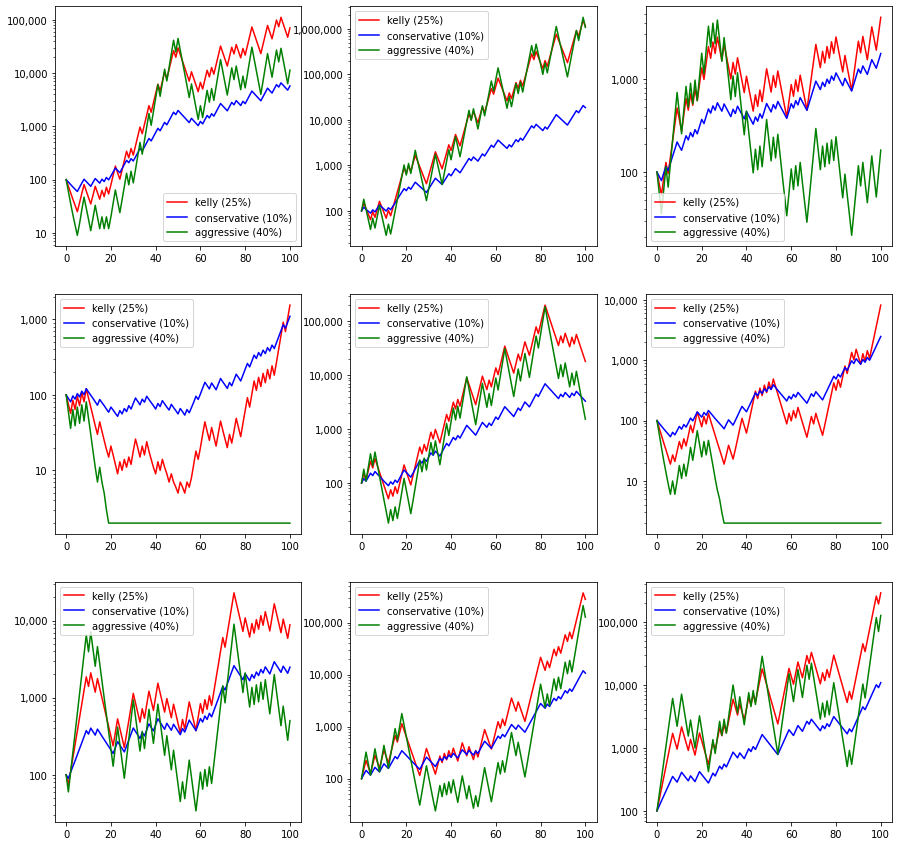

In [2]:
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

fig, axs = plt.subplots(3, 3, figsize=(15,15))

for rw in range(3):
  for col in range(3):
    flips = coin_flips(100)
    ax = axs[rw, col]
    ax.set_yscale('log')
    ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
    
    ax.plot(sim(0.25, flips), 'r', label='kelly (25%)')
    ax.plot(sim(0.1, flips), 'b', label="conservative (10%)")
    ax.plot(sim(0.4, flips), 'g', label="aggressive (40%)")
    ax.legend()


All the simulations above share the same "market conditions" - i.e., the
sequence of coin flips is the same for the graphs in each chart.  You can
see that the aggressive fraction (green) is occasionally wiped our (or
nearly wiped out) in some scenarios.

# Managing Risk

Using the Kelly Criteria is the optimal way to maximize your long-term growth.
But it is still very susceptible to short-term volatility.  It also assumes that
you have correctly analyzed the risk of loss.  For this reason many
practitioners choose to wager only a *fraction* (like $\frac{1}{2}$) of the
suggested Kelly bet size in order to minimize the chance of being wiped out.

## Simulations to account for volatility

We show how the above scenario can perform very differently depending on the
randomness of betting outcomes.  We will calculate the average growth rate
(per bet) over 100 bets, for a range of betting-fractions from 5% to 50% of
your stake (recalling that 25% was the theoretical optimum for this example).

In [3]:
# For each percentage bet size, calculate:
# min growth rate
# max growth rate
# average growth rate
# stddev of growth rate

from numpy import mean, std, percentile

NUM_RUNS = 300

def effective_growth_rate(balances):
  periods = len(balances) - 1
  net = balances[-1]/balances[0]
  return net**(1/periods) - 1

def strategy_stats():
  x_values = list(range(5, 50 + 1, 5))
  growth_rates = {}
  for _ in range(NUM_RUNS):
    flips = coin_flips(100)
    for percentage in x_values:
      if not percentage in growth_rates:
        growth_rates[percentage] = []
      balances = sim(percentage / 100, flips)
      growth_rates[percentage].append(effective_growth_rate(balances))
  
  stats = {}
  for percentage in x_values:
    rates = growth_rates[percentage]
    stats[percentage] = {
      'min': min(rates),
      'max': max(rates),
      'avg': mean(rates),
      'stddev': std(rates),
      'p10': percentile(rates, 10),
      'p90': percentile(rates, 90)
    }

  return {
    'x': list(range(5, 50 + 1, 5)),
    'min': [stats[percentage]['min'] for percentage in x_values],
    'max': [stats[percentage]['max'] for percentage in x_values],
    'avg': [stats[percentage]['avg'] for percentage in x_values],
    'stddev': [stats[percentage]['stddev'] for percentage in x_values],
    'p10': [stats[percentage]['p10'] for percentage in x_values],
    'p90': [stats[percentage]['p90'] for percentage in x_values]
  }
  return stats

    x       min       max       avg    stddev       p10       p90
0   5  0.002856  0.042970  0.021975  0.007750  0.011346  0.032017
1  10  0.000488  0.081722  0.039959  0.015646  0.018321  0.059948
2  15 -0.005095  0.115409  0.052639  0.023416  0.020344  0.082609
3  20 -0.031676  0.144463  0.060487  0.031391  0.017751  0.100491
4  25 -0.034458  0.168714  0.063136  0.039762  0.010453  0.113367
5  30 -0.034458  0.188074  0.061005  0.047686 -0.001636  0.121269
6  35 -0.038365  0.202526  0.053728  0.055240 -0.038365  0.124341
7  40 -0.038365  0.212006  0.043584  0.059738 -0.038365  0.122235
8  45 -0.038365  0.216011  0.028207  0.062567 -0.038365  0.114886
9  50 -0.045007  0.214195  0.009994  0.063275 -0.045007  0.101905


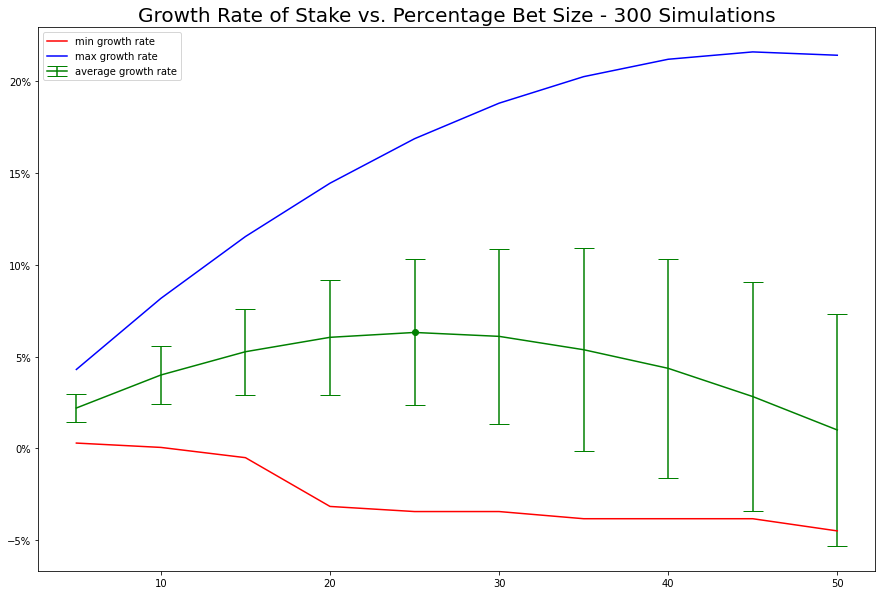

In [4]:
import pandas as pd

stats = strategy_stats()

print(pd.DataFrame(stats))

index_25 = stats['x'].index(25)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title(f"Growth Rate of Stake vs. Percentage Bet Size - {NUM_RUNS} Simulations",
  fontdict={'fontsize': 20})
plt.errorbar(stats['x'], stats['avg'], fmt='-g', yerr=stats['stddev'], capsize=10, label="average growth rate")
plt.plot(stats['x'], stats['min'], '-r', label="min growth rate")
plt.plot(stats['x'], stats['max'], '-b', label="max growth rate")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.plot([25], [stats['avg'][index_25]], 'og')
plt.legend()
None

# Kelly can still be "high risk"

I've displayed the minimum and maximum returns (expressed as a percentage
gain per bet) relative to our stake size as well as the average (in green).  You
can see that Kelly does in fact select the highest average returns across
these 300 simulation runs.  But using Kelly also exposes you to large losses
(negative returns) in some scenarios.

The error bars display $\pm 1$ standard deviation from the mean; that would
indicate that you'd expect about 68% of scenarios to fall withing that range.

In real life, we don't get to choose the average results over 300 trials - we
have one life, and have to live with our choices.  So, it is prudent to give
up some upside, when it is unacceptable to have the risk of substantial loses.

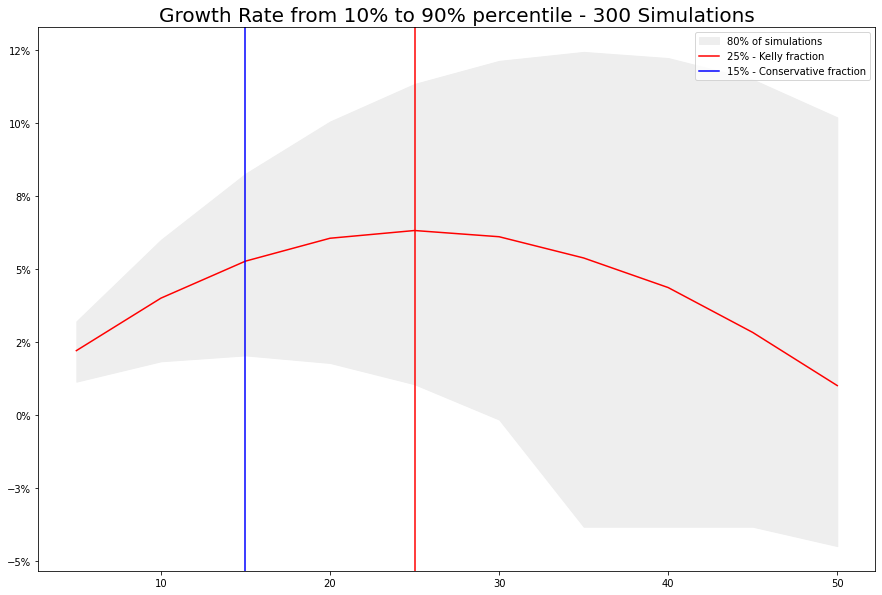

In [5]:
fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title(f"Growth Rate from 10% to 90% percentile - {NUM_RUNS} Simulations",
  fontdict={'fontsize': 20})
plt.fill_between(stats['x'], stats['p10'], stats['p90'], color="#eee", label="80% of simulations")
plt.plot(stats['x'], stats['avg'], '-r')
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.axvline(x = 25, color = 'red', label="25% - Kelly fraction")
plt.axvline(x = 15, color = 'blue', label="15% - Conservative fraction")
plt.legend()

# Application of Kelly to more Traditional Investments

We don't often expect to lose all of our investment as a likely outcome (unless,
perhaps, you are investing in start-up companies).  We can use a modified form
of Kelly for cases where you have one probability of a bet increasing in value,
and the inverse probability for it to decrease by another value.

$$\begin{aligned}
f = \frac{p}{a} - \frac{1-p}{b}
\end{aligned}$$

where:

- **$p$** - is the probability of the investment gaining in value.
- **$b$** - is the amount the value will increase (e.g 0.1 for a 10% increase).
- **$a$** - is the amount the value will decreases if it declines.

This is really just an exchange of variables; instead of risking "1" to get b,
we are risking "a" to get "b".

# Investing in the S&P

Let's take the example of investing in the S&P 500.  We can model historical
returns as being a random choice of a "good year" and a "bad year".  To
which we will assign a probability and a percent gain or loss.

# Building the Model

We start by reading in the historical data for the S&P and determining
what the good and bad years were.

    year  return
0   2021  0.2871
1   2020  0.1840
2   2019  0.3149
3   2018 -0.0438
4   2017  0.2183
..   ...     ...
91  1930 -0.2490
92  1929 -0.0842
93  1928  0.4361
94  1927  0.3749
95  1926  0.1162

[96 rows x 2 columns]


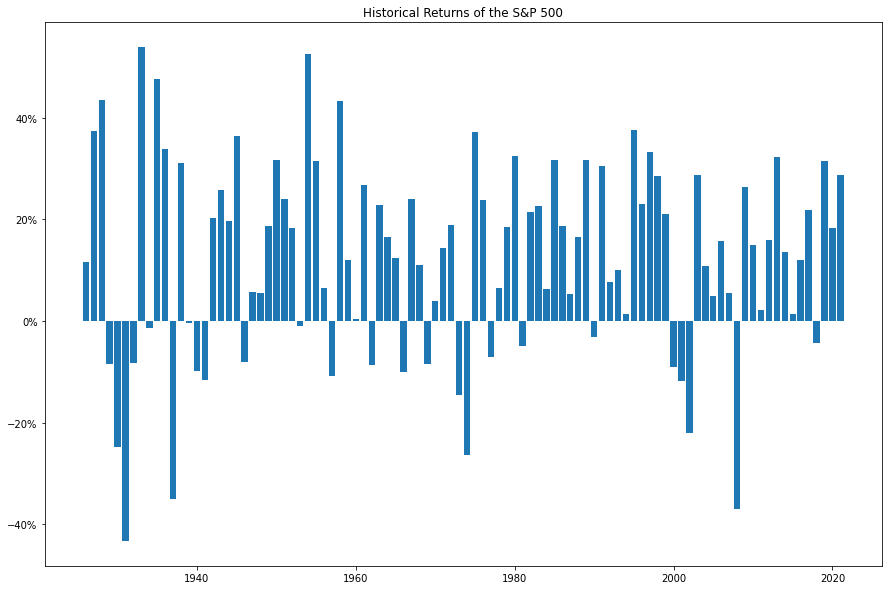

In [18]:
import csv

with open("data/history.csv", 'r') as f:
  reader = csv.reader(f)
  history = []
  for row in reader:
    history.append({
      'year': int(row[0]),
      'return': float(row[1])/100
    })

df = pd.DataFrame(history)
print(df)

fig, ax = plt.subplots()
fig.set_size_inches(15, 10)
plt.title(f"Historical Returns of the S&P 500")
ax.yaxis.set_major_formatter(ticker.PercentFormatter(xmax=1, decimals=0))
plt.bar(df['year'], df['return'])
None


In [27]:
from math import prod

positive_returns = [r for r in df['return'] if r > 0]
negative_returns = [r for r in df['return'] if r < 0]

print(f"{len(positive_returns)} up years, and {len(negative_returns)} down years")

def net_growth_rate(returns):
  periods = len(returns)
  net = prod(returns)
  return net**(1/periods) - 1

model = {
  'a': net_growth_rate(negative_returns),
  'b': net_growth_rate(positive_returns)
}
model

71 up years, and 25 down years


{'a': (-0.9154359396297569+0.010682925185451988j), 'b': -0.8382027913649195}

In [23]:
negative_returns

[-0.0438,
 -0.37,
 -0.221,
 -0.1189,
 -0.091,
 -0.031,
 -0.049100000000000005,
 -0.0718,
 -0.2647,
 -0.1466,
 -0.085,
 -0.10060000000000001,
 -0.0873,
 -0.10779999999999999,
 -0.009899999999999999,
 -0.08070000000000001,
 -0.1159,
 -0.0978,
 -0.0040999999999999995,
 -0.3503,
 -0.0144,
 -0.0819,
 -0.4334,
 -0.249,
 -0.0842]